In [34]:
import networkx as nx
import os.path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import tifffile as tiff
import math
from scipy import spatial

In [ ]:
# defining the paths and all the relvant settings 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
in_path = '/content/drive/My Drive/Colab Notebooks/skull_data_graphs/'
edges = "edges_skull_ffoc_upsamp_392_ROI6.csv"
nodes = "nodes_skull_ffoc_upsamp_392_ROI6.csv"
img = "stack_ROI6.tif"

# sacling to make comparable to node positions 
# scaling factor for ROI6: 0.00252525
pix_size = 0.00252525

In [37]:
# function for graph creation
def create_graph(nodesFile, edgesFile, index_addon = None):
    """ Creates a networkX undirected multigraph from provided csv files.

    Paramters
    ---------
    nodesFile: A csv file containing information about the nodes
    edgesFile: A csv file containing information about the edges
    id: an identifier to avoid ambiguous combinations of graphs

    Returns
    -------
    G: A networkX multigraph object
    """
    if type(nodesFile) ==str and type(nodesFile) ==str :
        nodes = pd.read_csv(nodesFile, sep = ";", index_col= "id")
        edges = pd.read_csv(edgesFile, sep = ";", index_col= "id")
    else:
        nodes = nodesFile
        edges = edgesFile
    # create undirected graph 
    G = nx.MultiGraph()


    if index_addon is not None:
        for idxN, node in nodes.iterrows():
            G.add_node(str(int(idxN)) + index_addon, x = (), pos = (float(node["pos_x"]),float(node["pos_y"]), float(node["pos_z"])))

        # add the edges
        for idxE, edge in edges.iterrows():
            G.add_edge(str(int(edge["node1id"]))  + index_addon , str(int(edge["node2id"])) + index_addon, x = (edge[2:])) # edge["distance"], edge["length"], edge["minRadiusAvg"], edge["curveness"], edge["avgRadiusStd"], edge["num_voxels"]

    else:
        for idxN, node in nodes.iterrows():
            G.add_node(idxN, x = (), pos = (float(node["pos_x"]),float(node["pos_y"]), float(node["pos_z"])))

        # add the edges
        for idxE, edge in edges.iterrows():
            G.add_edge(edge["node1id"],edge["node2id"], x = (edge[2:]), length = edge["length"])

    return G



# function for graph plotting

def plt_graph(graph, special_nodes = []):
    """ Creates a 3D matplotlib visualization of a networkx graph.

    Paramters
    ---------
    graph: A networkx graph
    special_nodes: A node list of nodes that should be distinctly visualized

    """
    # Create a 3D plot object
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ## Draw the edges in the plot
    for edge in graph.edges():
        ax.plot(xs=[graph.nodes[edge[0]]["pos"][0], graph.nodes[edge[1]]["pos"][0]],
                ys=[graph.nodes[edge[0]]["pos"][1], graph.nodes[edge[1]]["pos"][1]],
                zs=[graph.nodes[edge[0]]["pos"][2], graph.nodes[edge[1]]["pos"][2]], alpha = 0.2, color = "blue")

    # Draw the nodes in the plot
    for node in graph.nodes():
        if node not in special_nodes:
            ax.scatter(graph.nodes[node]["pos"][0], graph.nodes[node]["pos"][1], graph.nodes[node]["pos"][2], alpha = 0.2, color = "black")
        else: 
            ax.scatter(graph.nodes[node]["pos"][0], graph.nodes[node]["pos"][1], graph.nodes[node]["pos"][2], alpha = 0.4, color = "red")

    # Set the axis labels and title of the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Plot of Graph')

    # Show the plot
    plt.show()



def find_neighboring_nodes(graph, kd_tree, pixel_dist, pixel_size):
    """ Finds the nodes that of a graph that are closes than a certain distance any of the points stored in a KD-Tree. The distance is specified as the product of pixel_dist and pixel_size.

    Paramters
    ---------
    graph: A networkx graph
    kd_tree: KD-tree of points whos distance to the nodes should be evaluated
    pixel_dist: How many pixels side lengths the nearest point in the KD-tree can be away, to still be a neighboring point
    pixel_size: The side length of a single pixel in the data

    Returns
    -------
    result_nodes: A list of nodes that fullfill the proximity criterion to the points in the KD-tree

    """
    result_nodes = []
    for node in graph.nodes():
        val =graph.nodes()[node]["pos"]
        dd_m, _ = kd_tree.query(val, k = 1, distance_upper_bound = pixel_dist*pixel_size)
        if not math.isinf(dd_m):
            result_nodes.append(node)

    return result_nodes



def find_shortest_path_lengths(graph, source_nodes, target_nodes):
    """ For every source node the length shortest path in the graph to one of the target nodes is calculated.

    Paramters
    ---------
    graph: A networkx graph
    source_nodes: List of nodes of all starting points of shortest paths
    target_nodes: List of nodes of all allowed end points of shortest paths


    Returns
    -------
    path_lengths: The length of the shortest path for every start node.

    """
    path_lengths = []
    for node_m in source_nodes:
        shortest_m = 10
        for node_b in target_nodes:
            dist =  nx.shortest_path_length(graph,node_m, node_b, weight= "length") # shortest_path if you really want the path
            if dist < shortest_m:
                shortest_m = dist
        path_lengths.append(shortest_m)

    return path_lengths


def find_shortest_path(graph, source_nodes, target_nodes):
    """ For every source node the shortest path (list of nodes along the way) in the graph to one of the target nodes is calculated.

    Paramters
    ---------
    graph: A networkx graph
    source_nodes: List of nodes of all starting points of shortest paths
    target_nodes: List of nodes of all allowed end points of shortest paths


    Returns
    -------
    shortest_paths: The list of nodes along the shortest path for the shortest path for every start node.

    """
    path_lengths = []
    shortest_paths = []
    for node_m in source_nodes:
        shortest_m = 10
        path_of_shortest = None
        for node_b in target_nodes:
            dist =  nx.shortest_path_length(graph,node_m, node_b, weight= "length") # shortest_path if you really want the path
            path =  nx.shortest_path(graph,node_m, node_b, weight= "length") # shortest_path if you really want the path
            if dist < shortest_m:
                shortest_m = dist
                path_of_shortest = path
        path_lengths.append(shortest_m)
        shortest_paths.append(path_of_shortest)

    return shortest_paths


def graph_summary(G):
    """ Prints out a quick summary of the characteristics of a networkX graph.

    Paramters
    ---------
    G: A networkX graph object 

    """
    nodeNum = G.order()
    edgeNum = G.size()
    con_comp = nx.algorithms.components.number_connected_components(G)
    self_loops = nx.number_of_selfloops(G)
    avg_deg_multi = edgeNum*2/nodeNum
    isolatedNodes = len(list(nx.isolates(G)))

    print("***************")
    print("Number of Nodes: " +  str(nodeNum))
    print("Number of Edges: " + str(edgeNum))
    print("Number of Connected Components: " + str(con_comp))
    print("Number of Self Loops: " + str(self_loops))
    print("Number of Isolated Nodes: " + str(isolatedNodes))
    print("Average Node Degree: " + str(avg_deg_multi))    
    print("***************")
    return



def stat_along_path(graph, path, stat):
    """ Calculated the statistic along a path.

    Paramters
    ---------
    graph: A networkX graph 
    path: The path defined as list of nodes
    stat: The characteristic of interest

    """
    res = []
    for i in range(len(path)-1):
        val = graph.edges[(path[i], path[i+1],0)]["x"][stat]
        res.append(val)
    
    return res


## Visualizing the Graph

#### Full Graph

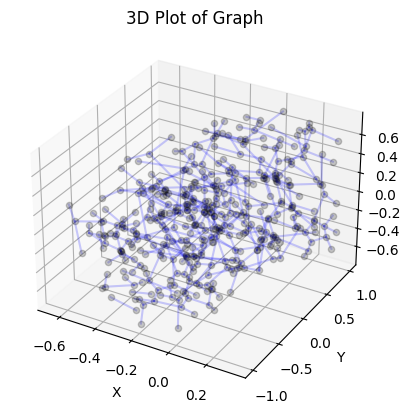

***************
Number of Nodes: 399
Number of Edges: 440
Number of Connected Components: 13
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.2055137844611528
***************


In [38]:
graph_nx = create_graph(os.path.join(in_path, nodes), os.path.join(in_path, edges))
plt_graph(graph_nx)
graph_summary(graph_nx)

#### Extracting the largest connected component and visualizing the respective graph

[355, 12, 6, 6, 4, 2, 2, 2, 2, 2, 2, 2, 2]


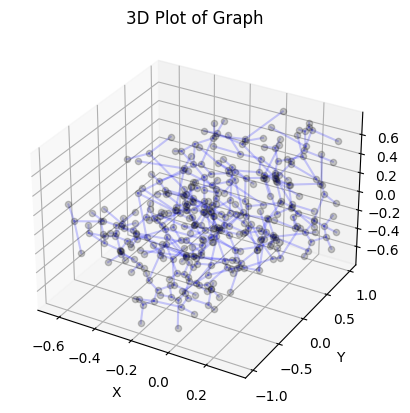

***************
Number of Nodes: 355
Number of Edges: 407
Number of Connected Components: 1
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.2929577464788733
***************


In [39]:
# get the largest connected component others are probably irrelevant
print(sorted([len(x) for x in list(nx.connected_components(graph_nx))], reverse = True))
graph_nx_cc = graph_nx.subgraph(max(nx.connected_components(graph_nx), key=len)).copy()
plt_graph(graph_nx_cc)
graph_summary(graph_nx_cc)

#### Loading the segmentation for meninges and bone marrow

In [40]:
seg_img = tiff.imread(os.path.join(in_path,img)).T
print(seg_img.shape)
print (seg_img.shape)

meninges = np.array(np.where(seg_img == 2))
bone_marrow =   np.array(np.where(seg_img == 254))


meninges_sc = meninges*  pix_size
bone_marrow_sc =  bone_marrow*  pix_size

meninges_sc[0,:] -= seg_img.shape[0]*1/2*  pix_size
meninges_sc[1,:] -= seg_img.shape[1]*1/2*  pix_size
meninges_sc[2,:] -= seg_img.shape[2]*1/2*  pix_size

bone_marrow_sc[0,:] -= seg_img.shape[0]*1/2*  pix_size
bone_marrow_sc[1,:] -= seg_img.shape[1]*1/2*  pix_size
bone_marrow_sc[2,:] -= seg_img.shape[2]*1/2*  pix_size

menginges_kd = spatial.KDTree(meninges_sc.T)
bone_marrow_kd = spatial.KDTree(bone_marrow_sc.T)

(520, 792, 456)
(520, 792, 456)


#### Finding nodes from the skull channels that are directly boardering the meninges or the skull

In [41]:
mening_nodes = []
bone_marrow_nodes = []

# setting max allowed distance
pixel_dist = 20


mening_nodes = find_neighboring_nodes(graph_nx_cc, menginges_kd, pixel_dist, pix_size)
bone_marrow_nodes = find_neighboring_nodes(graph_nx_cc, bone_marrow_kd, pixel_dist, pix_size)

print(len(mening_nodes))
print(len(bone_marrow_nodes))

11
22


#### Plotting the nodes that are attached to the meninges (red)

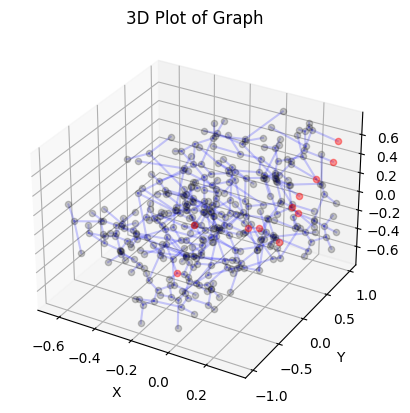

In [42]:
plt_graph(graph_nx_cc, mening_nodes)

#### Plotting the nodes that are attached to the bone marrow (red)

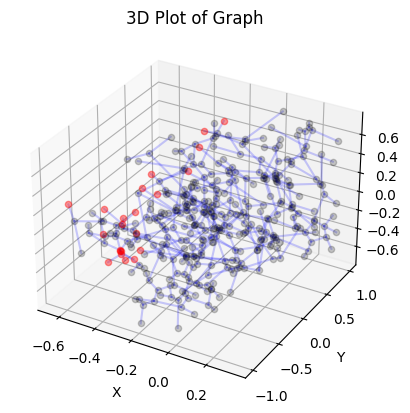

In [43]:
plt_graph(graph_nx_cc, bone_marrow_nodes)

## Analysis of Path Characteristics

#### Length of paths and no. of nodes along paths

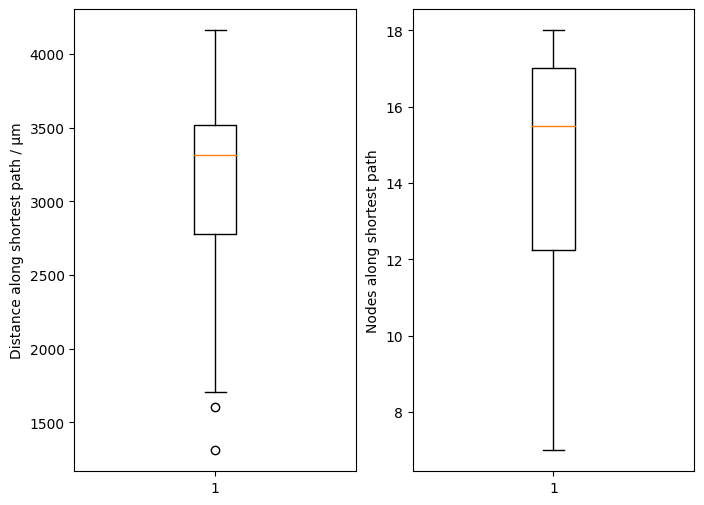

Mean length of the shortest path 3115.6274
Mean number of the edges along the shortest path 13.9545


In [44]:
path_lengths = find_shortest_path_lengths(graph_nx_cc, bone_marrow_nodes, mening_nodes)
path_lengths_real_length = np.array(path_lengths)/pix_size*3.92  # 3.92 µm is the size of each pixel 
paths = find_shortest_path(graph_nx_cc, bone_marrow_nodes, mening_nodes)


fig, ax = plt.subplots(1,2, figsize = (8,6))
# shows how long distance wisw the paths are
ax[0].boxplot(path_lengths_real_length)
ax[0].set_ylabel("Distance along shortest path / µm")
# shows along how many edges the path goes 
ax[1].boxplot([len(p) for p in paths])
ax[1].set_ylabel("Nodes along shortest path")
plt.show()

print(f"Mean length of the shortest path {np.mean(path_lengths_real_length):.4f}")
print(f"Mean number of the edges along the shortest path {np.mean([len(p) for p in paths]):.4f}")

#### Average radius and cross section along path

In [45]:
avgRadavg_paths = []
avgCross_sec_paths = []

for path in paths:
    rad = stat_along_path(graph_nx, path, "avgRadiusAvg") #avgCrossSection # minRadiusAvg
    avgRadavg_paths.append(np.mean(rad))
    cross_sec = stat_along_path(graph_nx, path, "avgCrossSection") #avgCrossSection # minRadiusAvg
    avgCross_sec_paths.append(np.mean(cross_sec))

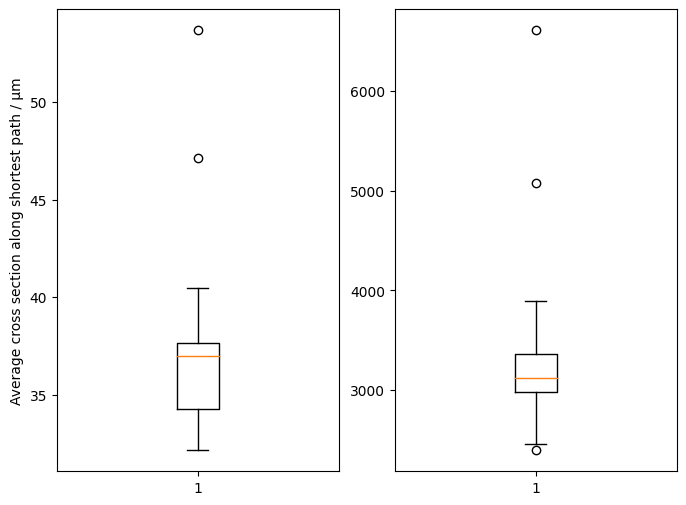

In [46]:
avgRadavg_paths_sc = np.array(avgRadavg_paths)/pix_size*3.92  # 3.92 µm is the size of each pixel 
avgCross_sec_paths_sc = np.array(avgCross_sec_paths)*(3.92/pix_size)**2  # scaling for area

fig, ax = plt.subplots(1,2, figsize = (8,6))
# means the abg radius along the path is ~ 35 µm
ax[0].boxplot(avgRadavg_paths_sc)
ax[0].set_ylabel("Average radius along shortest path / µm")
ax[1].boxplot(avgCross_sec_paths_sc)
ax[0].set_ylabel("Average cross section along shortest path / µm")
plt.show()


#### Larger Boxplots with more detailed labels

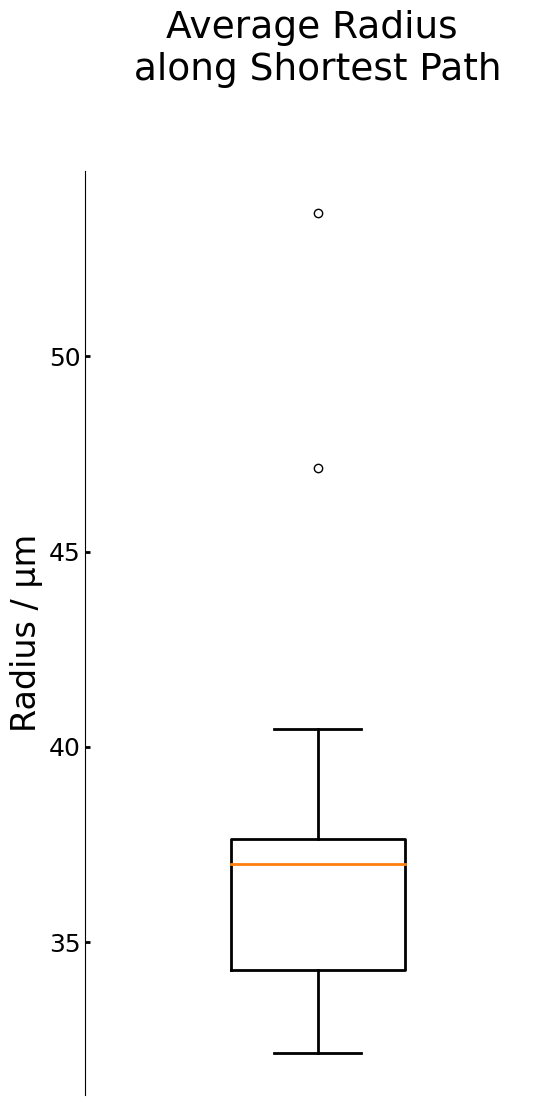

In [47]:
# Create boxplot
fig, ax = plt.subplots(figsize=(6, 12))
ax.boxplot(avgRadavg_paths_sc)

# Set axis labels and tick label positions

ax.set_ylabel('Radius / µm', fontsize=24)
ax.tick_params(axis='y', labelsize=18, direction='in', width=2)


# Set plot title
ax.set_title('Average Radius \n along Shortest Path \n \n', fontsize=27)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)

# Set scaling such that the box fills the plot
#ax.set_ylim(20, 60)
ax.set_xlim(0.8, 1.2)

# Remove xticks and x labels
ax.set_xticks([])
ax.set_xlabel('')
for line in ax.lines:
    line.set_linewidth(2)


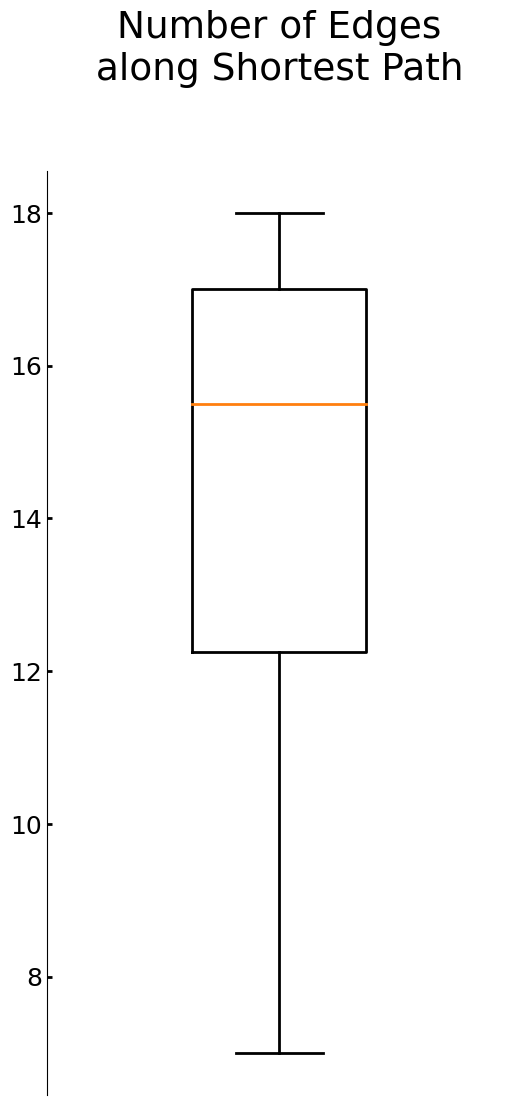

In [48]:
# Create boxplot
fig, ax = plt.subplots(figsize=(6, 12))
ax.boxplot([len(p) for p in paths])
ax.tick_params(axis='y', labelsize=18, direction='in', width=2)

# Set plot title
ax.set_title('Number of Edges\n along Shortest Path \n \n', fontsize=27)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)

# Set scaling such that the box fills the plot
ax.set_xlim(0.8, 1.2)

# Remove xticks and x labels
ax.set_xticks([])
ax.set_xlabel('')
for line in ax.lines:
    line.set_linewidth(2)


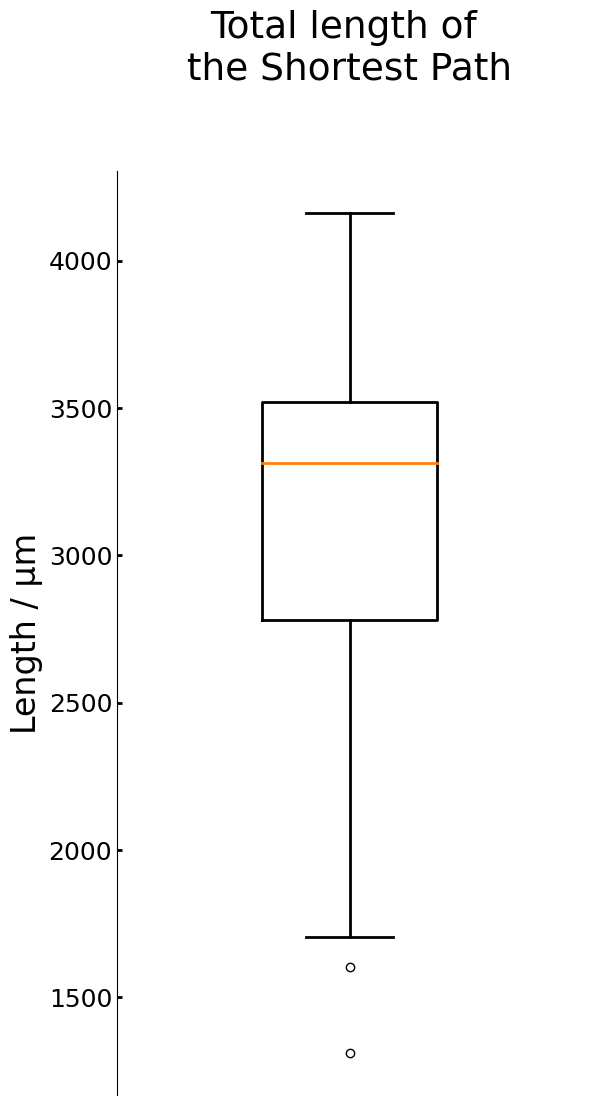

In [49]:
# Create boxplot
fig, ax = plt.subplots(figsize=(6, 12))
ax.boxplot(path_lengths_real_length)
ax.set_ylabel('Length / µm', fontsize=24)
ax.tick_params(axis='y', labelsize=18, direction='in', width=2)

# Set plot title
ax.set_title('Total length of \n the Shortest Path \n \n', fontsize=27)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)

# Set scaling such that the box fills the plot
ax.set_xlim(0.8, 1.2)

# Remove xticks and x labels
ax.set_xticks([])
ax.set_xlabel('')
for line in ax.lines:
    line.set_linewidth(2)
